## Fetch and setup

In [2]:
import numpy as np
import pandas as pd
from one.api import ONE
from psyfun import io
from psyfun.config import *
from psyfun import plots
import matplotlib as pl
from matplotlib import pyplot as plt

one = ONE()

# only run if first-time setup
# Fetching all session, insertion, and spike data
# DAVIDE: for some reason, fetching keeps getting interrupted by the absence of certain files/directories.
#%run -i fetchdata.py -a

# Load session and insertion metadata
df_sessions = pd.read_parquet(paths['sessions'])
df_insertions = pd.read_parquet(paths['insertions'])

# dropping na (PCA_DC)
df_sessions = df_sessions.query('n_tasks >= 2').dropna(subset=['task00_spontaneous_start', 'task01_spontaneous_start'])

# Create a DataFrame with eids (all sessions with a left vid), categorized by experimental group
eids_exp = df_sessions.loc[(df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True) & (df_sessions['control_recording'] == False), 'eid']
eids_cont = df_sessions.loc[(df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True) & (df_sessions['control_recording'] == True), 'eid']

- Only sessions with at least two tasks and no NaNs in the first epochs were kept.
- Also, only left cameras were taken.

In [3]:
# epochs
epoch_pre = [
    'task00_spontaneous', 
    'task00_rfm',
    'task00_replay'
]

epoch_post =[
    'task01_spontaneous', 
    'task01_rfm',
    'task01_replay'
]

In [4]:
# 5-min window

df_timings, col_names = io.sliding_epochs(df_sessions, return_cols=True)

## Video datasets quality control

c:\Users\marti\Documents\mainen\psychedelics\psyfun\plots.py:57: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_qc = df[qc_columns].replace(qcval2num)


'\nVideo data for most sessions, only three missing. Good?\n'

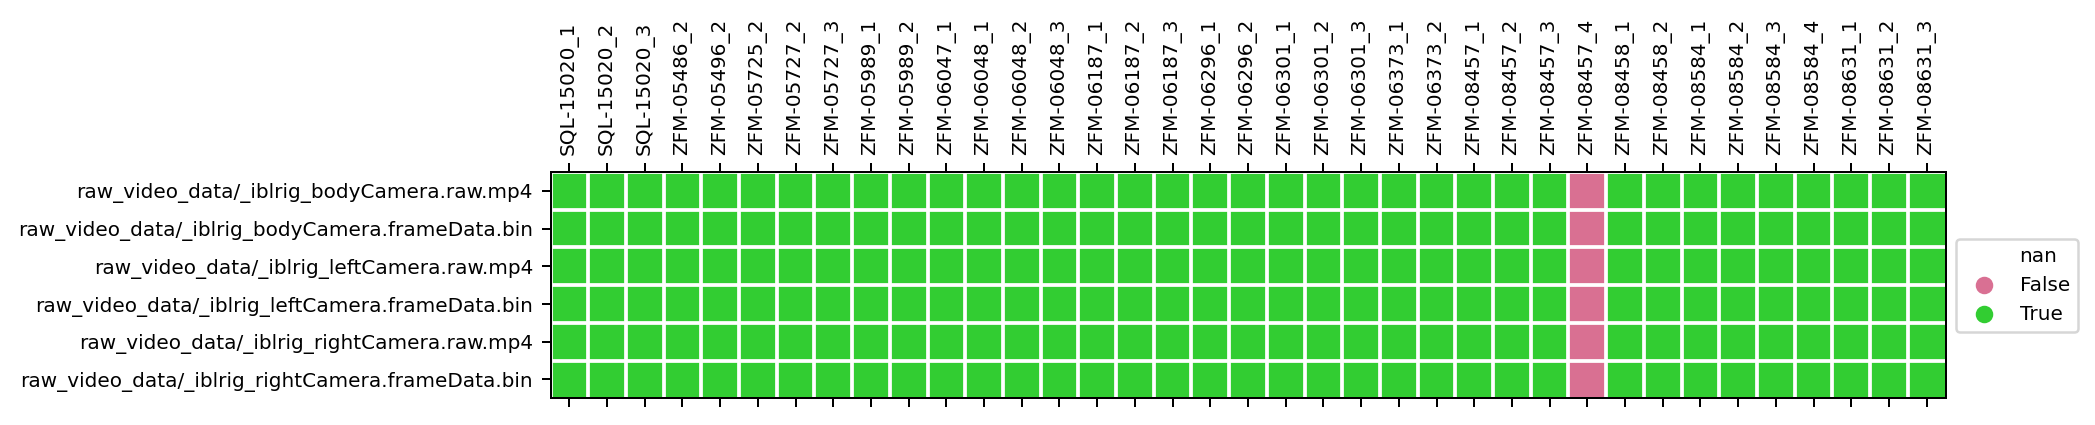

In [5]:
# Check which video datasets exist for each session
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_datasets['video'],  qcval2num=qcval2num, xticklabels=xticklabels)
fig = ax.get_figure()
fig.set_figwidth(10)

"""
Video data for most sessions, only three missing. Good?
"""

'\nLeft cameras have constant ~60FPS and a null number of dropped frames.\nThe one thing about higher FPS is that FaceMap will have to work with higher binning parameters to optimize the process,\ncausing a high loss of information.\n\nNonetheless, important to compare left and right video, especially because right videos also have a lower dropped-frame rate.\n'

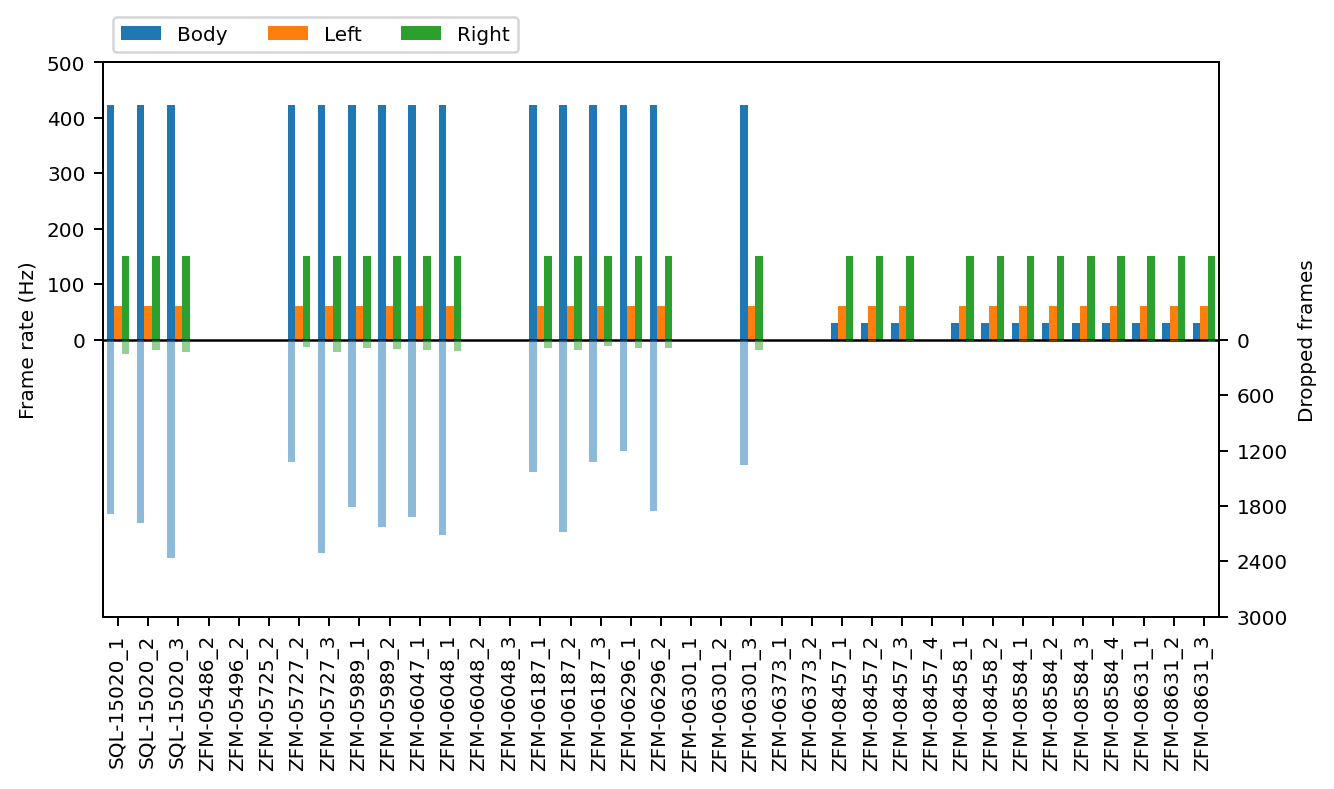

In [6]:
# Plot frame rate and number of dropped frames for each session & camera
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()

xpos = np.arange(len(df_sessions))

for offset, camera in zip([-0.25, 0., 0.25], ['Body', 'Left', 'Right']):
    framerate = df_sessions[f'video{camera}_framerate']
    ax.bar(xpos + offset, framerate, width=0.25, label=camera)
    dropped_frames = df_sessions[f'video{camera}_dropped_frames']
    ax2.bar(xpos + offset, -1 * dropped_frames, width=0.25, alpha=0.5)

ax.legend(loc='lower left', bbox_to_anchor=(0., 1.), ncol=3)

ax.set_xlim([-0.5, len(df_sessions) - 0.5])
ax.set_ylim([-500, 500])
ax.set_yticks(np.linspace(0, 500, 6))
ax.set_ylabel('Frame rate (Hz)')
ax2.set_ylim([-3000, 3000])
ax2.set_yticks(-1 * np.linspace(0, 3000, 6))
ax2.set_yticklabels(np.linspace(0, 3000, 6).astype(int))
ax2.set_ylabel('Dropped frames')
ax.axhline(0, color='black', lw=1)

ax.set_xticks(np.arange(len(df_sessions)))
ax.set_xticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.tick_params(axis='x', rotation=90)

"""
Left cameras have constant ~60FPS and a null number of dropped frames.
The one thing about higher FPS is that FaceMap will have to work with higher binning parameters to optimize the process,
causing a high loss of information.

Nonetheless, important to compare left and right video, especially because right videos also have a lower dropped-frame rate.
"""

# Attempts

In [35]:
from moviepy import VideoFileClip
import ibllib.io.video as vidio
import os

label = 'left'

video_path = one.eid2path(eids_exp[0])
video_path = os.path.join(video_path, "raw_video_data", "_iblrig_leftCamera.raw.mp4")
epochs = [
    ("example", 0, 60),  # (label, start, end)
]

with VideoFileClip(str(video_path)) as video:
    for label, start, end in epochs:
        clip = video.subclipped(start, end)
        out_path = f"{label}_clip.mp4"
        clip.write_videofile(out_path, codec="libx264")
#the subsampling wont work if less than 2000 frames (hence the reason) 33.3 second min

MoviePy - Building video example_clip.mp4.
MoviePy - Writing video example_clip.mp4



MoviePy - Done !
MoviePy - video ready example_clip.mp4


MoviePy - Done !
MoviePy - video ready example_clip.mp4


In [ ]:
import facemap


# Path to the video to process
videos = ["psychedelics/example_clip.mp4"]

# Run FaceMap processing with default parameters
facemap.mro

<module 'facemap.gui' (<_frozen_importlib_external._NamespaceLoader object at 0x0000027C9E955E10>)>

In [4]:
import facemap
import facemap.process
import scipy.io

from pathlib import Path


videos = ['example_clip.mp4']



facemap.process.run(videos)

KeyboardInterrupt: 

## my little suboptimal pca

In [21]:
from video_PCA import run_pca, get_frames, motion_energy
import gc 


# Use io.video to stream video data instead of dodwnloading full videos
import ibllib.io.video as vidio
label = 'left' # 'left', 'right' or 'body'

# Find url of video data to stream
url = vidio.url_from_eid(eid, one=one)[label]


# Get video metadata
meta = vidio.get_video_meta(url, one=one)
print(meta)

{'length': 233620, 'fps': 60, 'width': 1280, 'height': 1024, 'duration': datetime.timedelta(seconds=3893, microseconds=666667), 'size': 3803705393}


In [356]:
def get_frames_epoch(url, eid, pre = epoch_pre, post = epoch_post):
    """
    Loads video frames for each epoch defined in pre and post name sets. 
    Function only works with an imported 'df_sessions' dataframe.

    Returns two dictionaries, each with epoch names as keys and arrays of frames as values.

    Parameters
    ----------
    url : str
        Video file path or url.
    eid : str
        Experiment identifier

    epoch_pre : list
        List of pre-epochs (column names in df_sessions).
    epoch_post : list
        List of post-epochs (column names in df_sessions).
  

    Returns
    -------
    epoch_pre, epoch_post : dict
        Dictionary mapping epoch names to frames array.
    """
    epoch_pre = {}
    epoch_post = {}

    # Get fps from video metadata
    meta = vidio.get_video_meta(url, one=one)
    fps = meta['fps']

    # Helper single epoch
    def get_epoch_frames(epoch_name, eid):

        video_data = df_sessions.loc[df_sessions['eid'] == eid]

        # Get start and end times for this epoch
        start_time = video_data[f"{epoch_name}_start"]
        start_frame = int(round(start_time * fps))

        end_time = video_data[f"{epoch_name}_stop"]
        end_frame = int(round((end_time * fps)))

        # Load frames for this epoch
        frames = vidio.get_video_frames_preload(url, range(start_frame, end_frame + 1), mask=np.s_[...,0])
        return frames

    for epoch in epoch_pre:
        epoch_pre[epoch] = get_epoch_frames(epoch, eid)

    for epoch in epoch_post:
        epoch_post[epoch] = get_epoch_frames(epoch, eid)

    return epoch_pre, epoch_post


In [376]:
video_data = df_sessions.loc[df_sessions['eid'] == eid]


print(video_data['task00_spontaneous_start'].values[0])

0.0


In [ ]:
fps = meta.fps
video_data = df_sessions.loc[df_sessions['eid'] == eid]

    # Get start and end times for this epoch
start_time = video_data[f"{epoch_pre[0]}_start"].values[0]
start_frame = int(round(start_time * fps))

end_time = start_time+60 #video_data[f"{epoch_pre[0]}_stop"].values[0]
end_frame = int(round(end_time * fps))

print("start time: ", start_time, ", end time: ", end_time)
print("frame_idx = ", start_frame, ", end frame = ", end_frame)

# Load frames for this epoch
frames = vidio.get_video_frames_preload(video_path, range(start_frame, end_frame), mask=np.s_[...,0])


start time:  0.0 , end time:  60.0
frame_idx =  0 , end frame =  3600


In [ ]:
motion = motion_energy(frames)

In [ ]:
from video_PCA import run_ipca

pca, metrics = run_ipca(motion, 50, True)

In [383]:
import cv2
import numpy as np

def resize_batch(frames, scale=0.5):
    """
    Resize a batch of frames.
    frames: np.ndarray of shape (batch, height, width) or (batch, height, width, channels)
    scale: float, resize factor (e.g., 0.5 for half size)
    Returns: np.ndarray of resized frames, shape (batch, new_height, new_width) or (batch, new_height, new_width, channels)
    """
    batch, height, width = frames.shape[:3]
    new_size = (int(width * scale), int(height * scale))
    resized = []
    for i in range(batch):
        frame = frames[i]
        resized_frame = cv2.resize(frame, new_size, interpolation=cv2.INTER_AREA)
        resized.append(resized_frame)
    return np.stack(resized)

# Loop to import and resize frames in batches of 1000 until reaching end_frame (18000)
all_resized_frames = []
batch_size = 1000
for start in range(0, end_frame, batch_size):
    stop = min(start + batch_size, end_frame)
    frames_batch = vidio.get_video_frames_preload(video_path, range(start, stop), mask=np.s_[...,0])
    resized = resize_batch(frames_batch, scale=0.5)
    all_resized_frames.append(resized)

# Concatenate all resized frames into a single array
all_resized_frames = np.concatenate(all_resized_frames, axis=0)


In [ ]:
# Get the frames per epoch

def get_frames_epoch(url, epoch_set):
    
    
    for epoch in epoch_set:
        
    
    else:
        raise NameError(epoch, name= 'parameter not identified')
movie_components = []

# only two loops
for i in range(2):
    start = i * frames_per_batch
    frames_segment = get_frames(video_path, start, frames_per_batch)

    pixel_dif = motion_energy(frames_segment)
    del frames_segment
    gc.collect()

    pca_frames, _ = run_pca(pixel_dif, 0.8) # otherwise, run_pca(pixel_dif, 0.8)
    del pixel_dif
    gc.collect()
    
    movie_components.append(pca_frames.components_) # appends the components returned from iPCA that explain 80%var
    print(pca_frames.components_.shape)

# Stack all the segment components into one massive temporal matrix
movie_matrix = np.vstack(movie_components)

#print(f"Total segments: {n_segments}")

(14, 1310720) 19/20
(14, 1310720) 19/20


how is it possible that both chunks of 20 frames have the same number of components explaining 80% of the data.

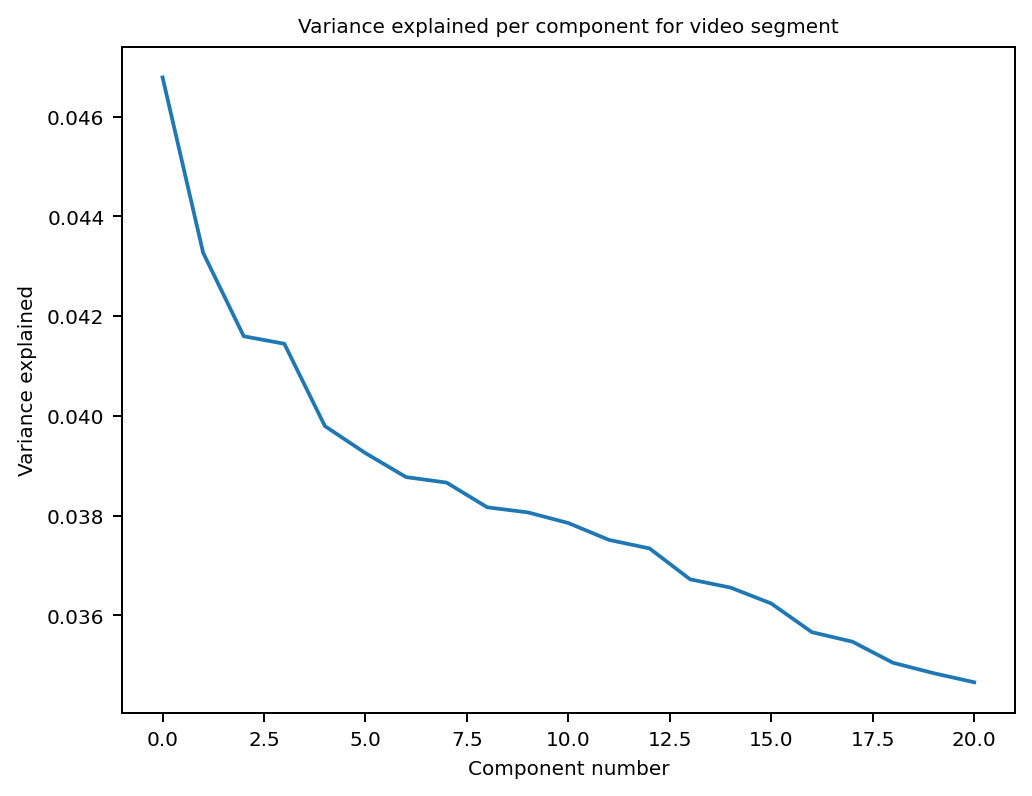

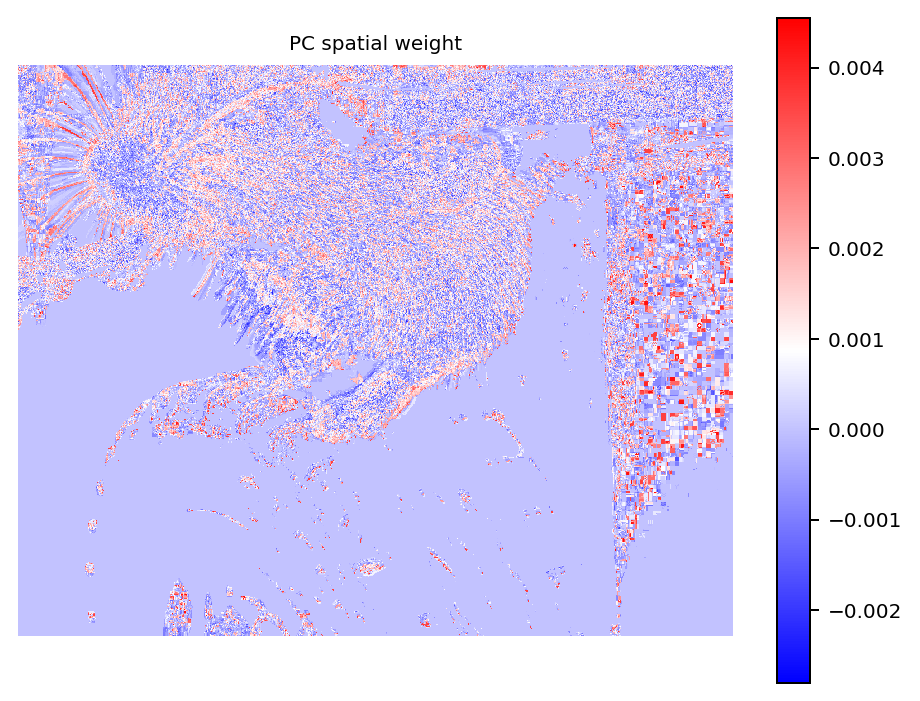

In [ ]:
moviepca, moviedict = run_pca(movie_matrix, 0.8, True)

# plotting spatial masks

height, width = meta['height'], meta['width']



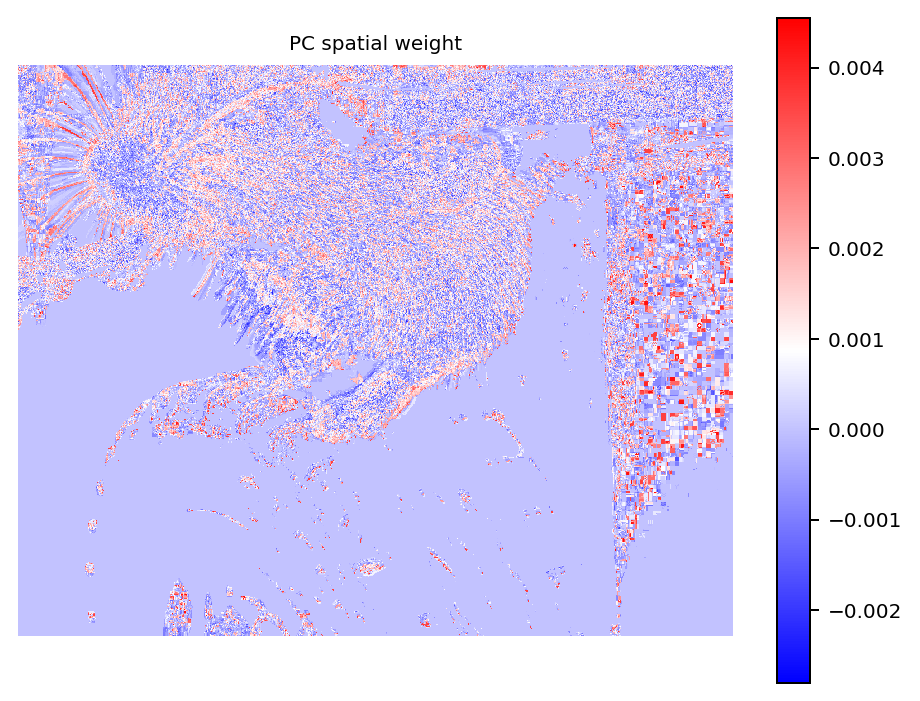

In [279]:
## first component

pc1 = moviepca.components_[0]

plt.figure()
plt.imshow(pc1.reshape((height, width)), cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.title('PC spatial weight')
plt.axis('off')
plt.show()

could use some ROI from facemap parameters - too many contributing pixels are found on the machine rather than the mice

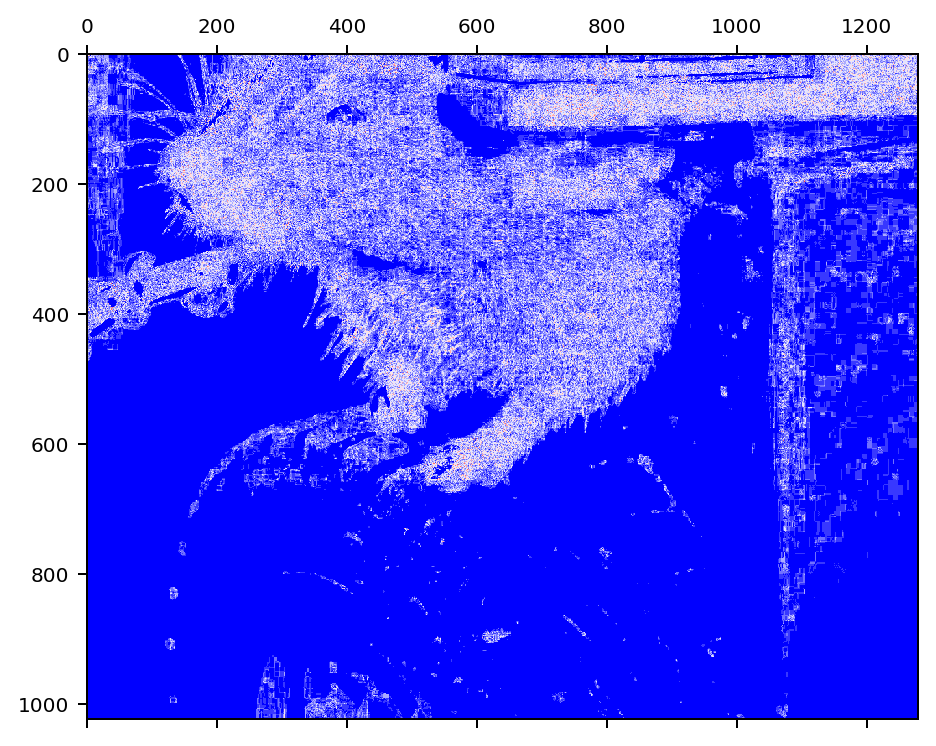

In [ ]:
# checking pixel differences

frames = vidio.get_video_frames_preload(video_path, range(10))
frame = frames[0,...]
assert np.allclose(frame[...,0], frame[...,1])
assert np.allclose(frame[...,0], frame[...,2])
assert np.allclose(frame[...,1], frame[...,2])

# plotting example frame
"""
I am concerned about luminosity at the wheel ROI - most of PC1 differences came from that section. Must check diff matrix
"""
#fig, ax = plt.subplots()
#ax.matshow(frame[...,0], cmap ='bwr', vmin = 0, vmax = 250)

# plotting average motion energy for 10 example frames
avg_diff = np.diff(frames[...,0], axis = 0)
avg_diff = np.mean(avg_diff, axis = 0)

fig1, ax1 = plt.subplots()
ax1.matshow(avg_diff, cmap = 'bwr', vmin = 0, vmax = 150)

# Analysis

Some things to consider before running a full-screen video analysis:

- There are prominent activity clusters in the machine side instead of the rodent.
- Defining ROI might be useful; must check if the shape of all videos is the same to integrate into the pipeline.
- ROI manipulation through the API is slightly more complex than through the GUI due to binning and standardization: need to use the transforms.

Edit (24/6/25):

- I've given up on trying to implement an automatic pipeline to run each video: the API resists any call within the code.
- With ~45 videos, I'll run the GUI with each and create an analysis pipeline for the results.

Edit (7/1/25)
- I ended up reimplementing a specialized version of Facemap that is finetuned to my purposes.
- Possible features include:
    - Bringing back the ROI modules (though I think they are still intact)
    - Giving more print progress statements

### Functions

In [5]:
import os
import numpy as np

def download_video(eid, camera = "left"):
    """
    Downloads raw video data from specific session. Camera parameter can be switched to "body" and "right".
    
    Parameters
    ----------
    eid (str): Experiment/session identifier

    camera (str): Camera orientation identifier (left by default). "body", "right" are other available options.

    Returns
    -------
    video_path: Local path for saved video
    """
    
    if camera == "left":
        video_path = one.load_dataset(eid, f'*leftCamera.raw*', collection='raw_video_data')
    elif camera == "right":
        video_path = one.load_dataset(eid, f'*rightCamera.raw*', collection='raw_video_data')
    elif camera == "body":
        video_path = one.load_dataset(eid, f'*bodyCamera.raw*', collection='raw_video_data')
    else:
         raise ValueError(f"Unknown camera parameter: {camera}")

    return video_path

def get_time_epochs(df_sessions, eid):

    video_data = df_sessions.loc[df_sessions['eid'] == eid]
    
    # epochs
    epoch_pre = [
        ("task00_spontaneous", video_data['task00_spontaneous_start'].values[0], video_data['task00_spontaneous_stop'].values[0]),
        ("task00_rfm", video_data['task00_rfm_start'].values[0], video_data['task00_rfm_stop'].values[0]),
        ("task00_replay", video_data['task00_replay_start'].values[0], video_data['task00_replay_stop'].values[0])
    ]

    epoch_post = [
        ("task01_spontaneous", video_data['task01_spontaneous_start'].values[0], video_data['task01_spontaneous_stop'].values[0]),
        ("task01_rfm", video_data['task01_rfm_start'].values[0], video_data['task01_rfm_stop'].values[0]),
        ("task01_replay", video_data['task01_replay_start'].values[0], video_data['task01_replay_stop'].values[0])
    ]

    return epoch_pre, epoch_post


# will be useful for multi-video analysis at the end
def load_pca_results(eid):
    """
    Imports FaceMap results on motion energy video analysis. Obtains path for .npy file based on eid, loads, and returns the data
    in a dictionary dataframe.

    Parameters
    ----------
        eid (str): Experiment/session identifier.

    Returns
    -------
        dictionary: Loaded PCA results.
        Keys() : (parameters )'filenames', 'save_path', 'Ly', 'Lx', 'sbin', 'fullSVD', 'save_mat', 'Lybin', 'Lxbin', 'sybin', 'sxbin', 'LYbin', 'LXbin',
                 (outputs) 'avgframe', 'avgmotion', 'avgframe_reshape', 'avgmotion_reshape', 'motion', 'motSv', 'movSv', 'motMask', 'movMask', 'motMask_reshape', 'movMask_reshape', 'motSVD', 'movSVD', 
                (unused tracking) 'pupil', 'running', 'blink', 'rois', 'sy', 'sx']
    """
    # Assuming consistent naming
    file_path = os.path.join(one.eid2path(eid), "raw_video_data", "_iblrig_leftCamera.raw_proc.npy")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"PCA results file not found: {file_path}")
    

    data = np.load(file_path, allow_pickle=True).item()
    return data


In [6]:
#----------------------ONLY RUN ONCE-----------------------------------
# Control group hasn't been loaded!!!

# experimental group (27 videos)

#for eid in eids_exp:
    #video_path = download_video(eid)

# Control group (9 videos)
#for eid in eids_cont:
    #video_path = download_video(eid)

## MotionMap: processing subclips

Things to think about:
- Computed_means() depends on a subset of frames in the subclip (e.g., average abs. motion energy in 1000 frames). Is that representative for an epoch (~18000 frames).
- Centering data is good too (machine motion gets cancelled in the final components, preventing the need of ROI feature)

In [7]:
def expected_path(video_path, start_sec, end_sec):
    """
    Constructs expected path to check if epoch was already processed.
    """
    basename, filename = os.path.split(video_path)
    filename, _ = os.path.splitext(filename)
    epoch_str = f"_start{int(start_sec)}_end{int(end_sec)}"
    expected_save = os.path.join(basename, f"{filename}{epoch_str}_proc.npy")

    return expected_save


In [15]:
import motionmap
import ibllib.io.video as vidio

results = []  # List to store (eid, epoch, savename)

for eid in eids_exp:
    # epoch timing 
    epoch_pre, epoch_post = get_time_epochs(df_sessions, eid)

    # Get video path
    url = one.eid2path(eid)
    if not os.path.exists(url):
        video_path = download_video(eid)
    
    video_path = os.path.join(url, "raw_video_data", "_iblrig_leftCamera.raw.mp4")
    path = [[video_path]]
    
    meta = vidio.get_video_meta(video_path)
    fps = meta['fps']

    # Run for each pre-epoch
    for epoch_name, start_sec, end_sec in epoch_pre:
        # expected save path
        expected_save = expected_path(video_path, start_sec, end_sec) 
        if os.path.exists(expected_save):
            print(f"Skipping {eid} pre_{epoch_name}: already processed at {expected_save}")
            results.append((eid, f'pre_{epoch_name}', expected_save))
            continue

        print("Running session: ", eid, " - epoch: ", epoch_name)
        savename = motionmap.run(path, sbin=4, start_sec=start_sec, end_sec=end_sec)
        results.append((eid, f'pre_{epoch_name}', savename))

    # Run for each post-epoch
    for epoch_name, start_sec, end_sec in epoch_post:
        expected_save = expected_path(video_path, start_sec, end_sec) 
        if os.path.exists(expected_save):
            print(f"Skipping {eid} post_{epoch_name}: already processed at {expected_save}")
            results.append((eid, f'post_{epoch_name}', expected_save))
            continue

        print("Running session: ", eid, " - epoch: ", epoch_name)
        savename = motionmap.run(path, sbin=4, start_sec=start_sec, end_sec=end_sec)
        results.append((eid, f'post_{epoch_name}', savename))

Skipping 58ca39c5-e27f-43c4-8516-2ccc4fe88042 pre_task00_spontaneous: already processed at C:\Users\marti\Downloads\ONE\alyx.internationalbrainlab.org\mainenlab\Subjects\SQL-15020\2023-03-21\001\raw_video_data\_iblrig_leftCamera.raw_start0_end300_proc.npy
Skipping 58ca39c5-e27f-43c4-8516-2ccc4fe88042 pre_task00_rfm: already processed at C:\Users\marti\Downloads\ONE\alyx.internationalbrainlab.org\mainenlab\Subjects\SQL-15020\2023-03-21\001\raw_video_data\_iblrig_leftCamera.raw_start300_end684_proc.npy
Skipping 58ca39c5-e27f-43c4-8516-2ccc4fe88042 pre_task00_replay: already processed at C:\Users\marti\Downloads\ONE\alyx.internationalbrainlab.org\mainenlab\Subjects\SQL-15020\2023-03-21\001\raw_video_data\_iblrig_leftCamera.raw_start684_end996_proc.npy
Skipping 58ca39c5-e27f-43c4-8516-2ccc4fe88042 post_task01_spontaneous: already processed at C:\Users\marti\Downloads\ONE\alyx.internationalbrainlab.org\mainenlab\Subjects\SQL-15020\2023-03-21\001\raw_video_data\_iblrig_leftCamera.raw_start28

In [20]:
results_df = pd.DataFrame(results)
results_df.columns = ["eid", "epoch", "savename"]

results_df.to_csv('exp_results', index=False)

Format of tuples will be (eid, epoch, savename). That way I can run group functions and have a more organized structure

## Loading results

In [ ]:
motion = results['motion'][0]

print(len(motion))

1800


In [ ]:
#print(len(results['motSVD']))
#print(results['motSVD'][1])

#print(results['motMask'][1][0])


print(len(results['motMask'][0]))


avgtest = np.stack(avgmotion, axis=0)
print(avgtest.shape)
print(avgtest)

65786
(256, 320)
[[8.494634   0.7836491  0.3111742  ... 0.88554287 0.7412878  0.86881316]
 [0.85315657 0.7337121  0.39501265 ... 0.81635106 0.7881945  0.6999999 ]
 [0.411553   0.32979795 0.31445706 ... 0.91900253 0.85744953 0.8291667 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
# Temporal masks: full video, frame-level SVD (frame x component)

frame_masks = results['motSVD']
frame_masks = np.stack(frame_masks[0], axis = 0) 
print(frame_masks.shape) 

# Eigenfaces: each 
eigenmsk = results ['motMask'] # binned pixels x components
eigenmsk=np.stack(eigenmsk[0], axis = 0)
print(eigenmsk.shape)

# Reshaped eigenfaces
re_eigenmsk = results['motMask_reshape'] # reshaped by bins (x, y, components)
re_eigenmsk=np.stack(re_eigenmsk[0], axis = 0)
print(re_eigenmsk.shape)

# Eigenvalues: they are in order (sanity check)
eigenval = results['motSv']

(1800, 500)
(81920, 500)
(256, 320, 500)


In [ ]:
avgfra = results['avgframe_reshape']

avgframes_reshaped = np.stack(avgfra, axis = 0)
print(avgframes_reshaped.shape)

(256, 320)


 I am confused as to what the dimensions mean? 
 - First, I ROIed only the rodent, shortening both axis. The binning parameter is 4, so dividing by 4???? idk
 - The binning really messes up the visual aspect of it, but price to pay i guess
 

#### Facemap mat parameters

In [ ]:
import scipy.io

mat_path = r"C:\Users\marti\Downloads\ONE\alyx.internationalbrainlab.org\mainenlab\Subjects\SQL-15020\2023-03-21\001\raw_video_data\_iblrig_leftCamera.raw_proc.mat"
mat_data = scipy.io.loadmat(mat_path)
print(mat_data)

#### some plotting

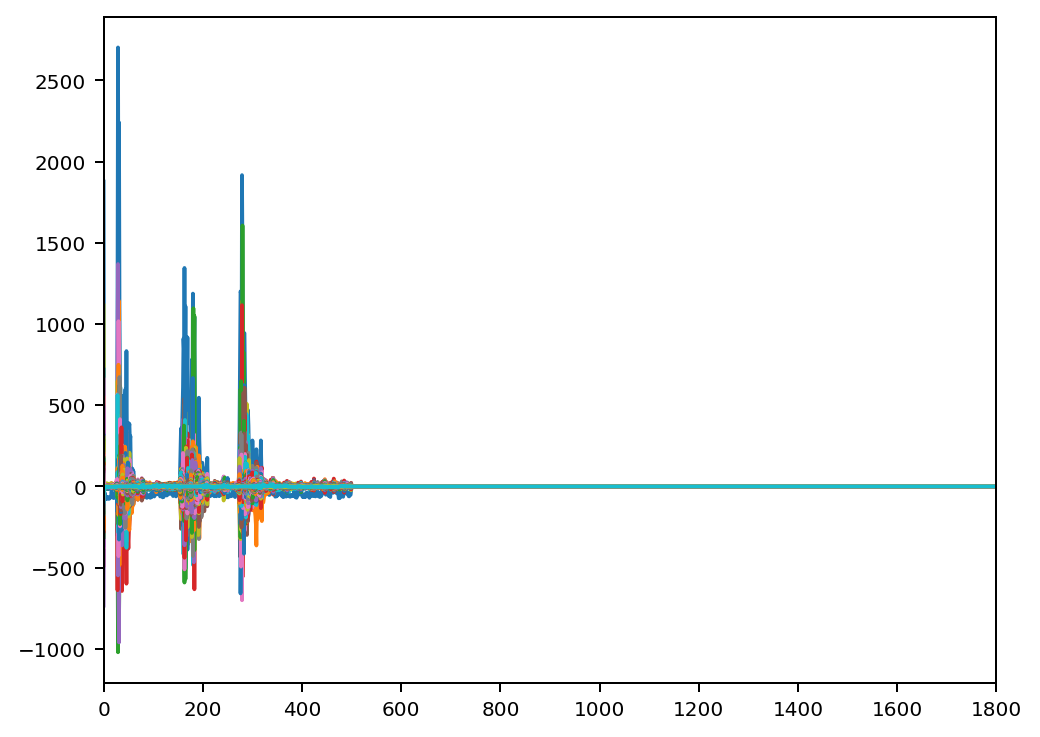

In [ ]:
# I'm missing the LSD timing protocol for comparison

fig, ax = plt.subplots()
ax.set_xlim(0,1800)
for col in range(1):
    ax.plot(frame_masks[:, :])


there is something really odd about this

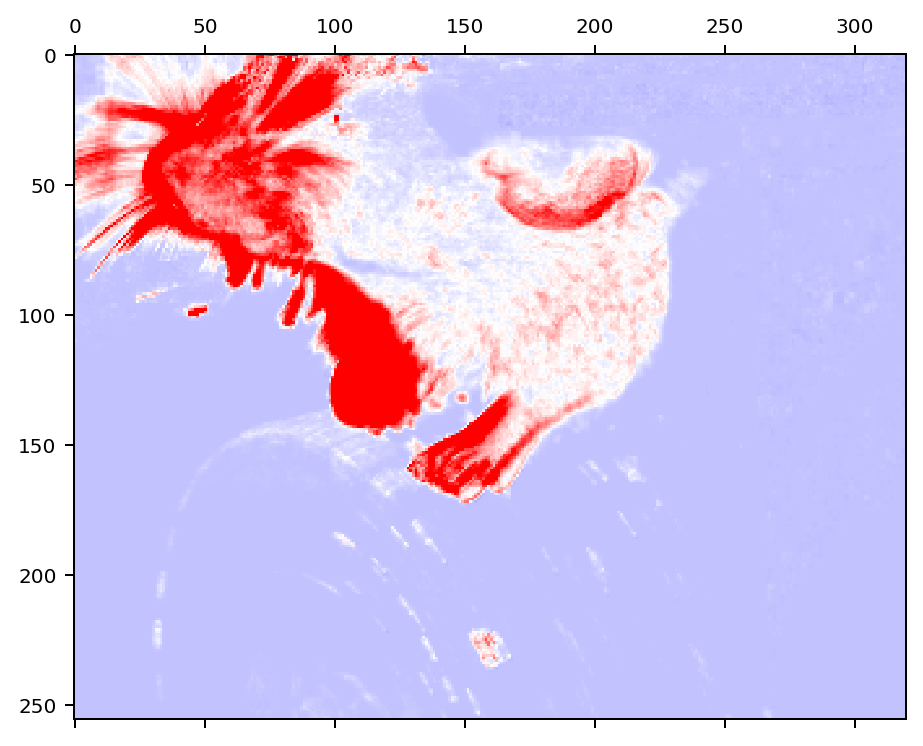

In [ ]:
# First eigenmask (by manual parameters)
fig, ax = plt.subplots()

ax.matshow(re_eigenmsk[:,:,0], cmap = 'bwr', vmin = -0.005, vmax = 0.005)

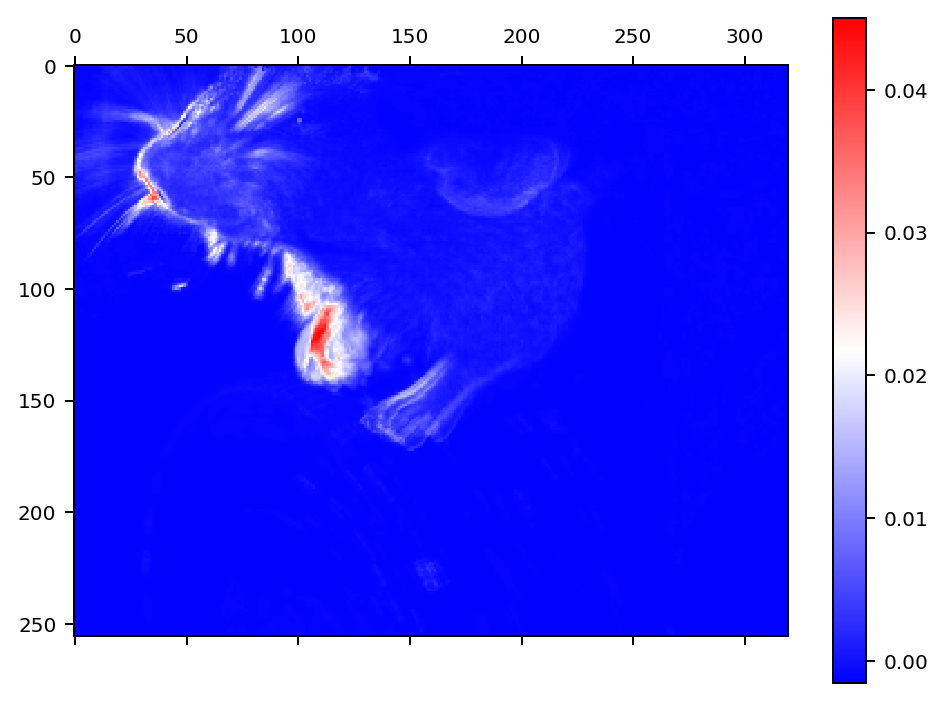

In [ ]:
# First eigenmask (by interpolation)
# I assume the change due to high values at the limb level,
# thus masking the other motion

fig, ax = plt.subplots()
im = ax.matshow(re_eigenmsk[:,:,0], cmap='bwr', interpolation='nearest')
fig.colorbar(im, ax=ax)

#### Interpretations

*frame_masks*

Frame masks allows a frame-level temporal matrix for each component in the video. With such a dataframe, we can observe the development of each component across the video. Mathematically, each row represents the variance contribution of all 500 components selected in the frame (comes from projecting  eigenmsk to groups of frames [1000]).

*eigenmsk*

Eigenfaces basically. They are flatpixel x component and show the loadings for each pixel in the frame.


to-do
Final figure:
1) Motion energy into component
2) Evolution of each component across the video (how do i plot epochs)


- Plot how the first 100 componenets change across the video.


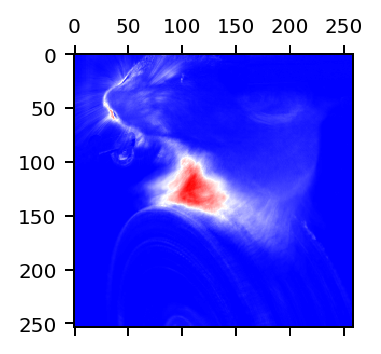

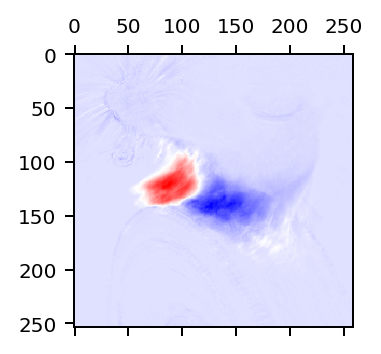

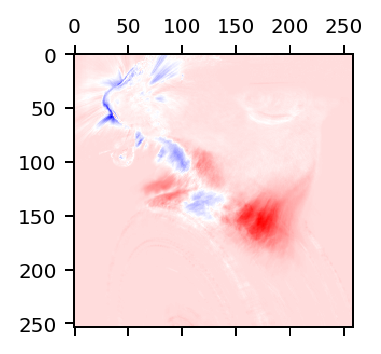

In [ ]:
for i in range(3):
    fig, axs = plt.subplots(figsize = (2,2))
    axs.matshow(re_eigenmsk[:,:,i], cmap = "bwr", interpolation = 'nearest')
    plt.show()

In [ ]:
# ffmpeg; video edit 

## Cross validation

### Cosine Similarity

comp1 shape is  (65786, 10)
comp2 shape is (65786, 10)
final shape is (10, 10)


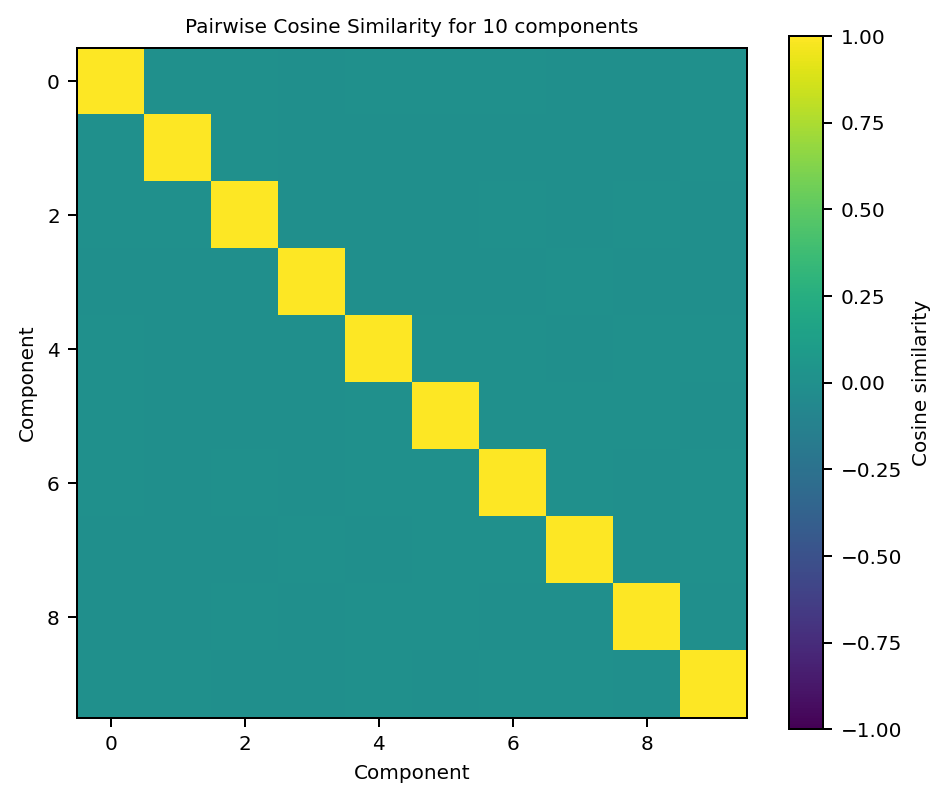

In [ ]:
def cosine_similarity_matrix(comp1, comp2, plot_matrix = False):
    """
    
    Computes cosine similarity matrix for two sets of components of the same shape.

    Parameters
    ----------
    comp1, comp2: shape (n_pixels, n_components)

    plot_matrix: False (default)
        If True, plots pairwise similarity matrix.

    Returns
    -------
    sim: np.array
        Cosine similarity matrix: shape (n_components, n_components)
    """
    comp1_norm = comp1 / np.linalg.norm(comp1, axis=0, keepdims=True)
    comp2_norm = comp2 / np.linalg.norm(comp2, axis=0, keepdims=True)

    print("comp1 shape is ", comp1_norm.shape)
    print("comp2 shape is", comp2_norm.shape)
    cosim = comp1_norm.T @ comp2_norm
    print("final shape is", cosim.shape)
    if plot_matrix:
        plt.figure(figsize=(6, 5))
        plt.imshow(cosim, cmap='viridis', vmin=-1, vmax=1)
        plt.colorbar(label='Cosine similarity')
        plt.title(f'Pairwise Cosine Similarity for {comp1_norm.T.shape[0]} components')
        plt.xlabel('Component')
        plt.ylabel('Component')
        plt.show()
        
    return cosim

# 10 first components
sim = cosine_similarity_matrix(eigenmsk[:,:10], eigenmsk[:,:10], True)

### Reconstruction error

In [ ]:
# Analyze example_clip.mp4 using the new streaming/batch FaceMap implementation
import facemap.process
import os
 
video_path = ['psychedelics/example_clip.mp4']
output_dir = os.path.join('psychedelics', 'video_results')
os.makedirs(output_dir, exist_ok=True)
 
# Run FaceMap in streaming mode (memory efficient, batch SVD)
result_path = facemap.process.run(video_path, sbin=4, motSVD=True, use_stream=True, batch_size=500, savepath=output_dir)
print(f"Processing complete. Results saved to: {result_path}")

AssertionError: Failed to open video file psychedelics\example_clip.mp4